In [2]:
cd ..

e:\deep learning python\facial_keypoint-training


C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Import packages

In [3]:
#inbuilt packages
import os
from PIL import Image
from tqdm import tqdm

#DataScience packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Pytorch related packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models

C:\Users\dell\AppData\Local\Temp\ipykernel_54724\2258200786.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Hyper Parameters

In [4]:
batch_size = 16
model_input_size = 224
n_epoch = 2
learning_rate = 0.001

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Data Loader

In [15]:
class FaceKeyPointData(Dataset):
    def __init__(self, csv_path='data/training_frames_keypoints.csv', split='training', device=torch.device('cpu')):
        super(FaceKeyPointData, self).__init__()
        self.csv_path = csv_path
        self.split = split
        self.df = pd.read_csv(self.csv_path)
        self.device = torch.device(device)
        # print(self.df)
        #self.model_input_size = model_input_size  # Define model_input_size
        self.normalize = transforms.Normalize(
            mean=[0.458, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img, original_size = self.get_img(index)
        key_points = self.get_keypoints(index=index, original_size=original_size)
        return img, key_points
    
    def get_img(self, index):
        # print(os.getcwd())
        # print(self.df.iloc[index,0])
        #os.path.join(, ,)
        img_path = os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index,0])
        img = Image.open(img_path).convert('RGB')
        original_size = img.size
        # print(original_size)

        ##preprocess image
        img = img.resize((model_input_size, model_input_size))
        # print(np.asarray(img)/255.0)
        img = np.asarray(img)/255.0
        # print(img.shape) #img tensor represent as batchsize,channel,width,height but here width,height,channel so use permute
        img = torch.tensor(img).permute(2, 0, 1)
        #print(img .shape)
        img = self.normalize(img)
        #print(img)

        # Convert images and keypoints to the correct data type
        img = img.float().to(device)  # Convert images to float32 and move to the correct device
         
        return img.to(self.device), original_size
    
    def get_keypoints(self, index, original_size):
        # print(self.df.iloc[index, 1:].tolist())
        kp = self.df.iloc[index, 1:].tolist()
        # kp = self.df.iloc[index, 1:].to_numpy().astype(np.float32) #kpx and kpy no need to convert in array then
        # print(kp)
        # kp_x = (np.array(kp[0::2])/original_size[0]).tolist()
        # kp_y = (np.array(kp[1::2])/original_size[1]).tolist()
        # kp = kp_x + kp_y
        kp_x = (np.array(kp[0::2])/original_size[0])
        kp_y = (np.array(kp[1::2])/original_size[1])
        kp = np.concatenate([kp_x, kp_y])

        # print(kp)
        # print(kp_x)
        # print(kp_y)
        # print(len(kp))
        return torch.tensor(kp).to(self.device)
    
    def load_img(self, index):
        img_path = os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index,0])
        img = Image.open(img_path).convert('RGB')
        img = img.resize((model_input_size, model_input_size))
        return np.asarray(img)/255.0


    
training_data = FaceKeyPointData(device=device)
training_data[0]
# len(training_data)
test_data = FaceKeyPointData(csv_path='data/test_frames_keypoints.csv', split='test', device=device )

In [9]:
# training_data.load_img(0)
# len(training_data)
# len(test_data)

In [10]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [27]:
# batch_img, batch_key_points = next(iter(train_dataloader))
# batch_img.shape

torch.Size([16, 3, 224, 224])

In [26]:
# batch_key_points.shape #16 batch size 

torch.Size([16, 136])

Data Visualization

C:\Users\dell\AppData\Local\Temp\ipykernel_50516\45430460.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(kp_s[:68]*model_input_size, kp_s[68:]*model_input_size, c='r',s=6, alpha=0.6, edgecolors='black', cmap='viridis')


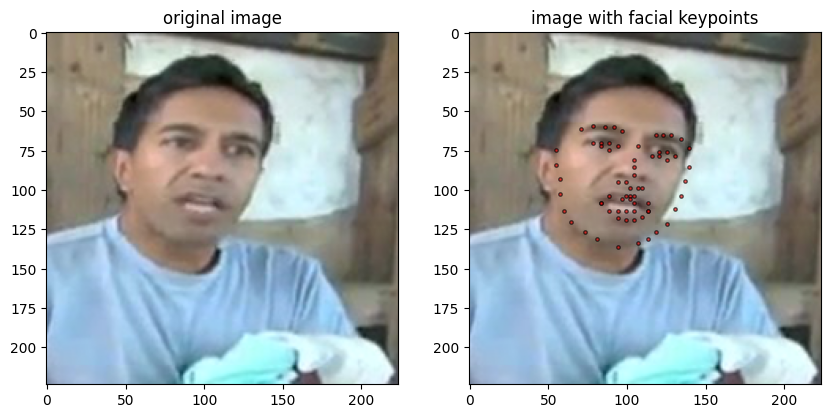

In [13]:
img_index = 20
img = training_data.load_img(20)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('original image')

plt.imshow(img)

plt.subplot(122)
plt.title('image with facial keypoints')
plt.imshow(img)

img_tensor, kp_s = training_data[img_index]
plt.scatter(kp_s[:68]*model_input_size, kp_s[68:]*model_input_size, c='r',s=6, alpha=0.6, edgecolors='black', cmap='viridis')



Model building

In [14]:
def get_model(device): 
  model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
  # print(vgg16)
  for layers in model.parameters():
    layers.requires_grad = False #no gradient descent work, layers donot optimize

  model.avgpool = nn.Sequential(
    nn.Conv2d(512, 512, 3),
    nn.MaxPool2d(2),
    nn.Flatten()
  )
  model.classifier=nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 136),
    nn.Sigmoid() #sigmoid/softmax:sigmoid every point probability 0 to 1
  )
  # print(model)
  return model.to(device=device)

model = get_model(device=device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
# loss=nn.L1Loss
criterion = nn.L1Loss()
optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
def train_batch(imgs, kps, model, criterion, optimizer):
  model.train()
  optimizer.zero_grad()

  #forward pass
  kps_pred=model(imgs)
  loss=criterion(kps_pred, kps)

  #backward pass
  loss.backward()
  optimizer.step()

  return loss


In [17]:
@torch.no_grad()
def validation_batch(imgs, kps, model, criterion):
  model.eval()

  kps_pred = model(imgs)
  loss = criterion(kps_pred, kps)
  return loss
  

Training pipeline

In [18]:
train_loss=[]
test_loss=[]

for epoch in range(1, n_epoch+1):
  epoch_train_loss, epoch_test_loss = 0,0

  #train
  for images, kps in tqdm(train_dataloader, desc=f'Training {epoch} of {n_epoch}'):
    #images, kps
    loss=train_batch(images, kps, model, criterion, optimizer)
    epoch_train_loss += loss.item()
  epoch_train_loss /= len(train_dataloader)
  train_loss.append(epoch_train_loss)

  #validation
  for images, kps in tqdm(test_dataloader, desc=f'Validation {epoch} of {n_epoch}'):
    loss=validation_batch(images, kps, model, criterion)
    epoch_test_loss += loss.item()
  epoch_test_loss /= len(test_dataloader) 
  test_loss.append(epoch_test_loss)

  print(f"Epoch {epoch} of {n_epoch}: Training loss: {epoch_train_loss}, Test loss: {epoch_test_loss}")
  

Validation 1 of 2: 100%|██████████| 49/49 [03:01<00:00,  3.69s/it]


Epoch 1 of 2: Training loss: 0.049324658121830095, Test loss: 0.0311181601399114


Validation 2 of 2: 100%|██████████| 49/49 [04:04<00:00,  4.99s/it]

Epoch 2 of 2: Training loss: 0.038537429668282275, Test loss: 0.027853981459790948


Train and Test  Lost Curve

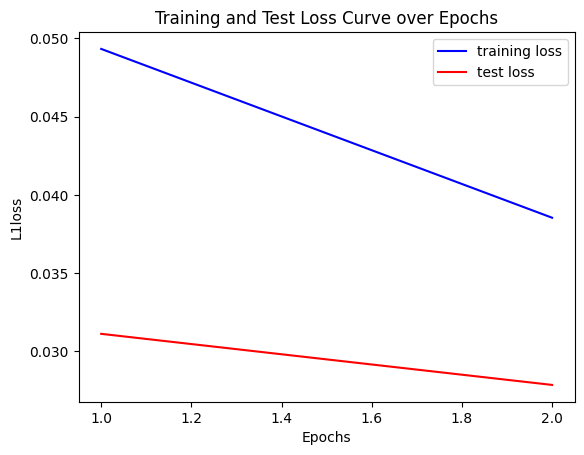

In [19]:
epochs = np.arange(1, n_epoch+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='training loss')
plt.plot(epochs, test_loss, 'r', label='test loss')
plt.title('Training and Test Loss Curve over Epochs')
plt.xlabel('Epochs')
plt.ylabel('L1loss')
plt.legend()
plt.show()

In [20]:
# print(f"Epochs length: {len(epochs)}")
# print(f"Training loss length: {len(train_loss)}")
# print(f"Test loss length: {len(test_loss)}")


Result Visualization 

C:\Users\dell\AppData\Local\Temp\ipykernel_50516\1212962562.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(kp_s[:68]*model_input_size, kp_s[68:]*model_input_size, c='r',s=6, alpha=0.6, edgecolors='black', cmap='viridis')


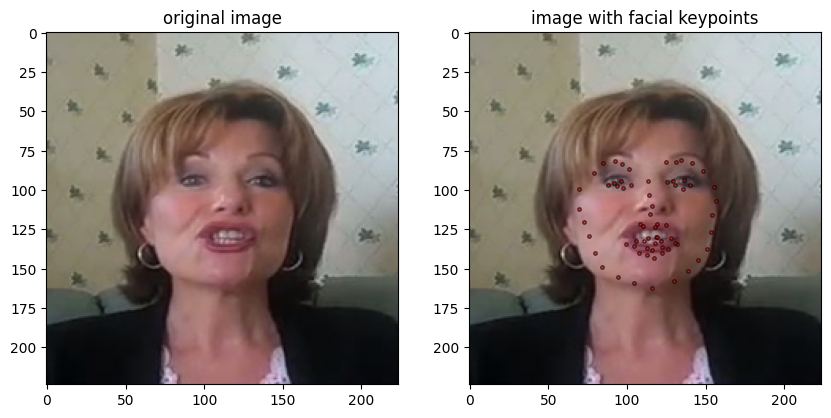

In [22]:
img_index = 10
img = test_data.load_img(10)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('original image')

plt.imshow(img)

plt.subplot(122)
plt.title('image with facial keypoints')
plt.imshow(img)

img, _ = test_data[img_index]
kp_s = model(img[None]).flatten().detach().cpu()

# img_tensor, kp_s = training_data[img_index]
plt.scatter(kp_s[:68]*model_input_size, kp_s[68:]*model_input_size, c='r',s=6, alpha=0.6, edgecolors='black', cmap='viridis')



C:\Users\dell\AppData\Local\Temp\ipykernel_50516\519094873.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(kp_s[:68]*model_input_size, kp_s[68:]*model_input_size, c='r',s=6, alpha=0.6, edgecolors='black', cmap='viridis')


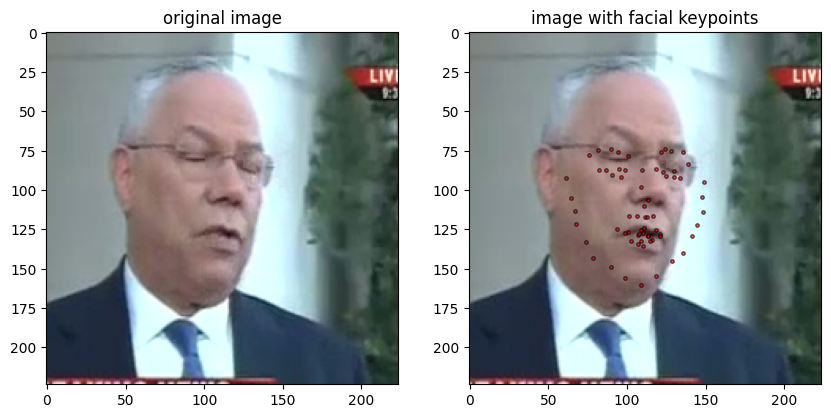

In [24]:
img_index = 20
img = test_data.load_img(20)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('original image')

plt.imshow(img)

plt.subplot(122)
plt.title('image with facial keypoints')
plt.imshow(img)

img, _ = test_data[img_index]
kp_s = model(img[None]).flatten().detach().cpu()

# img_tensor, kp_s = training_data[img_index]
plt.scatter(kp_s[:68]*model_input_size, kp_s[68:]*model_input_size, c='r',s=6, alpha=0.6, edgecolors='black', cmap='viridis')

In [23]:
# img, _ = test_data[img_index]
# img[None].shape

torch.Size([1, 3, 224, 224])

In [26]:
# model(img[None]).flatten().detach().cpu()

tensor([0.3791, 0.3876, 0.3917, 0.4031, 0.4109, 0.4231, 0.4357, 0.4714, 0.5065,
        0.5186, 0.5422, 0.5596, 0.5906, 0.5766, 0.6016, 0.5870, 0.6001, 0.4161,
        0.4242, 0.4311, 0.4478, 0.4622, 0.5059, 0.5303, 0.5414, 0.5643, 0.5785,
        0.4913, 0.4776, 0.4919, 0.5016, 0.4672, 0.4960, 0.5056, 0.5117, 0.5188,
        0.4403, 0.4466, 0.4532, 0.4748, 0.4394, 0.4488, 0.5258, 0.5329, 0.5400,
        0.5563, 0.5392, 0.5330, 0.4592, 0.4562, 0.4826, 0.4969, 0.5129, 0.5360,
        0.5317, 0.5307, 0.5137, 0.4927, 0.4886, 0.4728, 0.4527, 0.4802, 0.4948,
        0.5184, 0.5409, 0.5111, 0.4916, 0.4822, 0.4374, 0.4638, 0.4775, 0.5066,
        0.5279, 0.5596, 0.5676, 0.5608, 0.5703, 0.5749, 0.5412, 0.5421, 0.5217,
        0.4995, 0.4803, 0.4532, 0.4289, 0.3873, 0.3666, 0.3557, 0.3521, 0.3559,
        0.3570, 0.3693, 0.3650, 0.3710, 0.3715, 0.3969, 0.4337, 0.4436, 0.4676,
        0.4836, 0.4846, 0.4837, 0.4849, 0.4772, 0.4178, 0.4047, 0.3999, 0.4133,
        0.4271, 0.4303, 0.3996, 0.4145, 